# Models

Matt Thomas, Max McGaw, Liam Mulcahy, Will Carruthers

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import pandas as pd

In [2]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, NaiveBayes,\
LinearSVC, MultilayerPerceptronClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#We can use the sample.csv to speed things up while tuning models
df = spark.read.csv('train_data.csv', inferSchema=True, header=True)
#df = spark.read.csv('sample.csv', inferSchema=True, header=True)

In [5]:
df.show(2)

+------+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------------------+-------------+--------------+
|   _c0|loan_status_binary|loan_amnt|      term|int_rate|home_ownership|tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|debt_settlement_flag|grade_feature|emp_length_low|
+------+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------------------+-------------+--------------+
|625057|                 0|   4000.0| 36 months|   15.05|      MORTGAGE|   302373.0|  4558.1553|  100000.0|        CA|         675.0|        2899.73|                   N|           CD|             0|
|394994|                 0|  10000.0| 60 months|   12.69|      MORTGAGE|    93524.0|  11656.099|   80000.0|        WY|         660.0|         8055.0|                   N|           CD|             0|


In [5]:
dfs = df.select([col for col in df.columns if col not in ['_c0']])

In [6]:
dfs.show(5)

+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------------------+-------------+--------------+
|loan_status_binary|loan_amnt|      term|int_rate|home_ownership|tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|debt_settlement_flag|grade_feature|emp_length_low|
+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------------------+-------------+--------------+
|                 0|  20000.0| 60 months|     9.8|          RENT|    84037.0|   23387.47|   75000.0|        OH|         690.0|       13669.82|                   N|           AB|             0|
|                 0|   3000.0| 36 months|   14.08|          RENT|    27195.0|     1537.4|   24000.0|        TX|         695.0|         102.65|                   N|           CD|             1|
|                 0|  16000.0| 36 m

In [6]:
dfs.printSchema()

root
 |-- loan_status_binary: integer (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- tot_cur_bal: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- fico_range_low: double (nullable = true)
 |-- last_pymnt_amnt: double (nullable = true)
 |-- debt_settlement_flag: string (nullable = true)
 |-- pub_rec_bankruptcies: double (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- grade_feature: string (nullable = true)
 |-- emp_length_low: integer (nullable = true)



## Logistic Regression

Note that for all models, we ran using 5 fold cross validation on a sample of the training set first to find the best parameters, then used those parameters on the full set. You will see the cross validation models commented out but they have been run.

In [6]:
train, test = dfs.randomSplit([0.8, 0.2], seed=12345)

In [33]:
categories = ['home_ownership', 'term', 'debt_settlement_flag', 'grade_feature']
stages = []

In [34]:
for col in categories:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col + "_Index")
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(),
                            outputCol=col + "classVec")
    stages += [stringIndexer, encoder]

In [35]:
scaled_vectors = VectorAssembler(inputCols = ['loan_amnt',\
                                             'total_pymnt', 'annual_inc', \
                                             'fico_range_low', 'last_pymnt_amnt',\
                                             'int_rate','emp_length_low','tot_cur_bal',
                                             'delinq_2yrs', 'pub_rec_bankruptcies',\
                                             'chargeoff_within_12_mths'],
                                 outputCol='vector_features')

In [36]:
scaler = StandardScaler(inputCol='vector_features', outputCol='scaled_features')

In [37]:
labelIndexer = StringIndexer(inputCol='loan_status_binary', outputCol='label')

In [38]:
#AT added
assembler = VectorAssembler(inputCols=['scaled_features', 'home_ownershipclassVec', 'termclassVec', \
                                       'debt_settlement_flagclassVec','grade_featureclassVec' ], outputCol='features')

In [39]:
stages += [scaled_vectors, scaler, labelIndexer, assembler]

In [40]:
lr = LogisticRegression(maxIter=10, regParam=0.1)
stages += [lr]
stages

[StringIndexer_a32e05400966,
 OneHotEncoder_821ad289358b,
 StringIndexer_932588c27088,
 OneHotEncoder_8793c0c7cbe8,
 StringIndexer_def54d965252,
 OneHotEncoder_197b1e7f6714,
 StringIndexer_90b5a89221d5,
 OneHotEncoder_235e0672b633,
 VectorAssembler_6ed52ad14795,
 StandardScaler_3e4c50e017ba,
 StringIndexer_28fcba021dab,
 VectorAssembler_51d8837015b5,
 LogisticRegression_541550bbd4d4]

In [15]:
pipeline = Pipeline(stages=stages)

In [16]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, .001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.2, 0.8, 1.0])\
    .build()

In [17]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

In [18]:
# Fit the pipeline
model = crossval.fit(train)

In [19]:
# Make a prediction
prediction = model.transform(test)
prediction.show(2)

+------------------+---------+----------+--------+--------------+---------------+-----------+----------+----------+--------------+---------------+--------------------+--------------------+-----------+------------------------+-------------+--------------+--------------------+----------------------+----------+-------------+--------------------------+----------------------------+-------------------+---------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|loan_status_binary|loan_amnt|      term|int_rate|home_ownership|    tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|debt_settlement_flag|pub_rec_bankruptcies|delinq_2yrs|chargeoff_within_12_mths|grade_feature|emp_length_low|home_ownership_Index|home_ownershipclassVec|term_Index| termclassVec|debt_settlement_flag_Index|debt_settlement_flagclassVec|grade_feature_Index|grade_featureclassVec|     vector_features|     scaled_fe

In [20]:
prediction = prediction.withColumn("loan_status_binary", df["loan_status_binary"].cast('float'))
#This is necessary to compare predictions with actual values

In [20]:
#Calculates area under Precision-Recall curve
evaluator = BinaryClassificationEvaluator(labelCol='loan_status_binary', \
                                          metricName='areaUnderPR')

In [22]:
evaluator.evaluate(prediction) #calculates area under P-R curve

0.4319289607436008

In [21]:
f1_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction',\
                                                 labelCol='loan_status_binary',\
                                                 metricName='f1')

In [24]:
f1_evaluator.evaluate(prediction) #f1 score

0.8604322827914554

In [25]:
trainingSummary = model.bestModel.stages[-1].summary
trainingSummary.accuracy

0.8932127322833774

In [26]:
#There's probably a better way, but this shows the best parameters
bestPipeline = model.bestModel
bestLRModel = bestPipeline.stages[-1]
bestParams = bestLRModel.extractParamMap()
bestParams

{Param(parent='LogisticRegression_955aa510ab1f', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_955aa510ab1f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_955aa510ab1f', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_955aa510ab1f', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_955aa510ab1f', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_955aa510ab1f', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_955aa510ab1f', name='maxIter', doc='maximum number of iterations (>= 0)'): 

In [27]:
#plotting precision-recall curve
pr = trainingSummary.pr.toPandas()


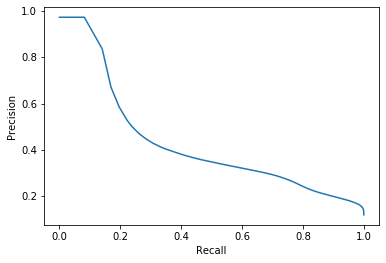

In [28]:
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Confusion Matrix

In [23]:
#from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import confusion_matrix

In [30]:
#predictionAndLabels = test.map(lambda lp: (float(model.predict(lp.features)), lp.label))
y_true = prediction.select("loan_status_binary")
y_true = y_true.toPandas()

y_pred = prediction.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0, 1])
cnf_matrix

array([[395643,   2712],
       [ 45557,   8085]])

In [26]:

import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[395643   2712]
 [ 45557   8085]]


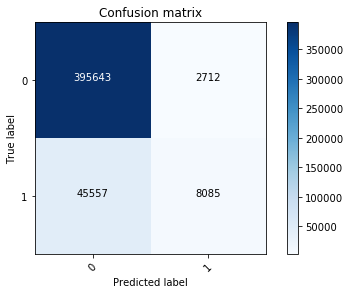

In [32]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix')
plt.show()

## Linear SVC

In [20]:
stages[-1] = LinearSVC(regParam = 0.001)

In [21]:
pipeline = Pipeline(stages=stages)

Note: In this and successive models, cross validation was run first to find the best parameters, then the full training set was run using the best parameter.

In [22]:
#paramGrid = ParamGridBuilder() \
  #  .addGrid(lr.regParam, [0.1, 0.01, .001]) \
   # .build()

In [23]:
#crossval = CrossValidator(estimator=pipeline,
 #                         estimatorParamMaps=paramGrid,
  #                        evaluator=BinaryClassificationEvaluator(),
   #                       numFolds=5)

In [24]:
# Fit the pipeline
#model_svc = crossval.fit(train)
model_svc = pipeline.fit(train)

In [25]:
# Make a prediction
prediction = model_svc.transform(test)

In [26]:
print(f'Area under P-R Curve is {evaluator.evaluate(prediction)}')
print(f'F1 Score is {f1_evaluator.evaluate(prediction)}')

Area under P-R Curve is 0.4267044686967332
F1 Score is 0.8575772281124808


In [29]:
#predictionAndLabels = test.map(lambda lp: (float(model.predict(lp.features)), lp.label))
y_true = prediction.select("loan_status_binary")
y_true = y_true.toPandas()

y_pred = prediction.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0, 1])
cnf_matrix

array([[398181,    174],
       [ 47119,   6523]])

Confusion matrix, without normalization
[[398181    174]
 [ 47119   6523]]


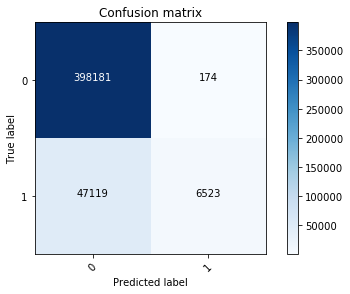

In [30]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix')
plt.show()

## Gradient Boosted Trees

In [9]:
categories = ['home_ownership', 'term', 'grade_feature', 'debt_settlement_flag']
stages = []

In [10]:


for col in categories:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col + "_Index")
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(),
                            outputCol=col + "classVec")
    stages += [stringIndexer, encoder]

In [11]:
vectors = VectorAssembler(inputCols = ['loan_amnt', 'home_ownershipclassVec', 'termclassVec',\
                                             'total_pymnt', 'annual_inc', \
                                             'fico_range_low', 'last_pymnt_amnt',\
                                             'int_rate','emp_length_low',\
                                       'delinq_2yrs', 'pub_rec_bankruptcies',\
                                      'grade_featureclassVec', 'debt_settlement_flagclassVec',\
                                      'chargeoff_within_12_mths'], 
                                 outputCol='features')

In [12]:
labelIndexer = StringIndexer(inputCol='loan_status_binary', outputCol='label')

In [13]:
gbt = GBTClassifier(maxDepth=12, maxBins=32, maxMemoryInMB=1024)
stages += [vectors, labelIndexer, gbt]

In [14]:
pipeline = Pipeline(stages=stages)

In [13]:
#paramGrid = ParamGridBuilder() \
    #.addGrid(gbt.maxDepth, [20]) \
    #.addGrid(gbt.maxBins, [50])\
    #.build()

In [14]:
#crossval = CrossValidator(estimator=pipeline,
                          #estimatorParamMaps=paramGrid,
                          #evaluator=BinaryClassificationEvaluator(),
                          #numFolds=5)

In [15]:
# Fit the pipeline
#model_gbt = crossval.fit(train)

In [16]:
model = pipeline.fit(train)

In [17]:
# Make a prediction
prediction = model.transform(test)

In [21]:
print(f'Area under P-R Curve is {evaluator.evaluate(prediction)}')
print(f'F1 Score is {f1_evaluator.evaluate(prediction)}')

Area under P-R Curve is 0.7548004010615161
F1 Score is 0.9184193824636018


In [24]:
#predictionAndLabels = test.map(lambda lp: (float(model.predict(lp.features)), lp.label))
y_true = prediction.select("loan_status_binary")
y_true = y_true.toPandas()

y_pred = prediction.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0, 1])
cnf_matrix

array([[395289,   3066],
       [ 29146,  24496]])

Confusion matrix, without normalization
[[395289   3066]
 [ 29146  24496]]


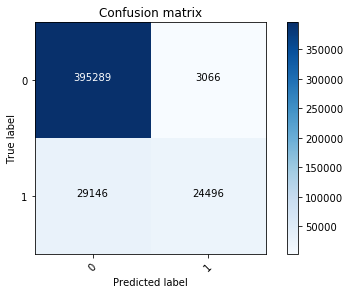

In [25]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix')
plt.show()

## Random Forest

In [14]:
rf = RandomForestClassifier(maxDepth=10, maxBins=25, numTrees=30, maxMemoryInMB=1024)
stages[-1] = rf

In [15]:
pipeline = Pipeline(stages=stages)

In [16]:
#paramGrid = ParamGridBuilder() \
    #.addGrid(rf.maxDepth, [5, 10]) \
    #.addGrid(rf.maxBins, [15, 20])\
    #.addGrid(rf.numTrees, [20, 25])\
    #.build()

In [17]:
#crossval = CrossValidator(estimator=pipeline,
 #                         estimatorParamMaps=paramGrid,
  #                        evaluator=BinaryClassificationEvaluator(),
   #                       numFolds=5)

In [18]:
# Fit the pipeline
#model_rf = crossval.fit(train)

In [19]:
model_rf = pipeline.fit(train)

In [20]:
# Make a prediction
prediction = model_rf.transform(test)

In [21]:
print(f'Area under P-R Curve is {evaluator.evaluate(prediction)}')
print(f'F1 Score is {f1_evaluator.evaluate(prediction)}')

Area under P-R Curve is 0.558452582079992
F1 Score is 0.8720891985185825


In [52]:
#Find Best Parameters
bestPipeline = model_rf.bestModel
bestLRModel = bestPipeline.stages[-1]
bestParams = bestLRModel.extractParamMap()
bestParams
#As with GBT, it wants higher values for parameters to improve performance

{Param(parent='RandomForestClassifier_dfd066075de7', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_dfd066075de7', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_dfd066075de7', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_dfd066075de7', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_dfd066075de7', 

In [24]:
#predictionAndLabels = test.map(lambda lp: (float(model.predict(lp.features)), lp.label))
y_true = prediction.select("loan_status_binary")
y_true = y_true.toPandas()

y_pred = prediction.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0, 1])
cnf_matrix

array([[397900,    455],
       [ 43640,  10002]])

Confusion matrix, without normalization
[[397900    455]
 [ 43640  10002]]


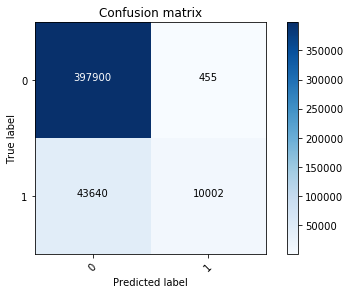

In [25]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix')
plt.show()

## Naive Bayes Model

In [28]:
categories = ['home_ownership', 'term', 'debt_settlement_flag', 'grade_feature']
stages = []

labelIndexer = StringIndexer(inputCol='loan_status_binary', outputCol='label')

for col in categories:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col + "_Index")
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(),
                            outputCol=col + "classVec")
    stages += [stringIndexer, encoder]

vectors = VectorAssembler(inputCols = ['loan_amnt', 'home_ownershipclassVec', 'termclassVec',\
                                             'total_pymnt', 'annual_inc', \
                                             'fico_range_low', 'last_pymnt_amnt',\
                                             'int_rate','emp_length_low',\
                                      'grade_featureclassVec','debt_settlement_flagclassVec',\
                                      'delinq_2yrs', 'pub_rec_bankruptcies'], 
                                 outputCol='vector_features')
assembler = VectorAssembler(inputCols=['vector_features', 'home_ownershipclassVec', 'termclassVec', \
                                       'debt_settlement_flagclassVec','grade_featureclassVec' ], outputCol='features')

In [29]:
nb = NaiveBayes(labelCol="label", featuresCol="vector_features", smoothing=1.0)

stages += [vectors, labelIndexer, nb]

pipeline = Pipeline(stages=stages)
# Create ParamGrid for Cross Validation
#nbparamGrid = (ParamGridBuilder()
               #.addGrid(nb.smoothing, [0.0,0.2, 0.4, 0.6, 0.8, 1.0])
               #.build())

# Evaluate model
#nbevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create 5-fold CrossValidator
#nbcv = CrossValidator(estimator = pipeline,
 #                   estimatorParamMaps = nbparamGrid,
  #                  evaluator=BinaryClassificationEvaluator(),
                    #evaluator = nbevaluator,
   #                 numFolds = 5)

In [30]:
model_n_bayes = pipeline.fit(train)

In [31]:
prediction = model_n_bayes.transform(test)

In [30]:
bestPipeline = model_n_bayes.bestModel
bestNBModel = bestPipeline.stages[-1]
bestParams = bestNBModel.extractParamMap()
bestParams

{Param(parent='NaiveBayes_da78cb5be033', name='featuresCol', doc='features column name'): 'vector_features',
 Param(parent='NaiveBayes_da78cb5be033', name='labelCol', doc='label column name'): 'label',
 Param(parent='NaiveBayes_da78cb5be033', name='modelType', doc='The model type which is a string (case-sensitive). Supported options: multinomial (default) and bernoulli.'): 'multinomial',
 Param(parent='NaiveBayes_da78cb5be033', name='predictionCol', doc='prediction column name'): 'prediction',
 Param(parent='NaiveBayes_da78cb5be033', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities'): 'probability',
 Param(parent='NaiveBayes_da78cb5be033', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name'): 'rawPrediction',
 Param(parent='NaiveBayes_da78cb5be033', name='smoothing', doc='The sm

In [32]:
print(f'Area under P-R Curve is {evaluator.evaluate(prediction)}')
print(f'F1 Score is {f1_evaluator.evaluate(prediction)}')

Area under P-R Curve is 0.15866705869250805
F1 Score is 0.5948647437797602


In [33]:
#predictionAndLabels = test.map(lambda lp: (float(model.predict(lp.features)), lp.label))
y_true = prediction.select("loan_status_binary")
y_true = y_true.toPandas()

y_pred = prediction.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0, 1])
cnf_matrix

array([[185433, 212816],
       [  3086,  50733]])

Confusion matrix, without normalization
[[184824 213531]
 [  2880  50762]]


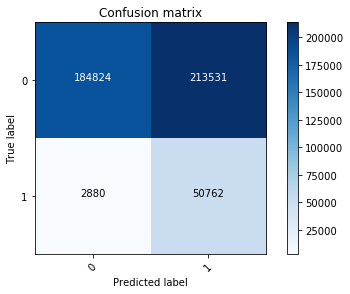

In [32]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix')
plt.show()